In [2]:
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import pickle
from adjustText import adjust_text

In [3]:
import re
from collections import Counter
pattern = r"([A-Z][a-z]?)(\d+)"
elt_pattern = re.compile(pattern)

In [4]:
with open('/large_experiments/opencatalyst/foundation_models/data/omol/processed/lmdbs/250430-release/raw/merged_metadata.pkl', 'rb') as fh:
    data = pickle.load(fh)

In [14]:
def get_is_good(split):
    is_good = set()
    for log_file in tqdm(glob.glob(f'/large_experiments/opencatalyst/foundation_models/data/omol/processed/lmdbs/250430-release/splits/data/{split}/log*')):
        with open(log_file, 'rb') as fh:
            log = pickle.load(fh)
        is_good.update(log['successful'])
    return is_good

In [ ]:
with open('/large_experiments/opencatalyst/foundation_models/data/omol/release/lmdbs/neutral_train/metadata.pkl', 'rb') as fh:
    data = pickle.load(fh)

In [6]:
def get_is_good(split):
    is_good = set()
    for log_file in tqdm(glob.glob(f'/large_experiments/opencatalyst/foundation_models/data/omol/release/lmdbs/neutral_train/log*')):
        with open(log_file, 'rb') as fh:
            log = pickle.load(fh)
        is_good.update(log['successful'])
    return is_good

In [15]:
splits_good = []
for split in ('train', 'val', 'test', 'metal_ligand_ood', 'uhs_ood'):
    splits_good.append(get_is_good(split))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1720.27it/s]


In [16]:
data_splits = [{}, {}, {}, {}, {}]
for k,v in tqdm(data.items(), total=len(data)):
    for idx, split in enumerate(splits_good):
        if k in split:
            data_splits[idx][k]=v
            break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157341882/157341882 [02:22<00:00, 1106135.00it/s]


In [17]:
[len(split) for split in data_splits]

[106528710, 2831506, 2875845, 44734, 24669]

In [18]:
def get_counts(data):
    stats = {}
    for key, val in tqdm(data.items(), total=len(data)):
        counts = Counter()    
        source = val['source']
        if 'omol' in source:
            parts = source.split('/')
            subdataset = parts[6]  # Directly access the part of the split list
            if subdataset in {'electrolytes', 'metal_organics'}:
                subdataset = '/'.join(parts[6:8])
        else:
            subdataset = source.split('/')[5]
        if subdataset in {'metal_organics/restart5to6', 'redo_orca6', 'metal_organics/outputs_072324', 'mo_hydrides'}:
            subdataset += f'_{int(val["spin"] > 2)}'
        for elt, count in elt_pattern.findall(val['composition']):
            counts[elt] += int(count)
        stats[source] = {'subdataset': subdataset, 'vertical': val['data_id'], 'elts': counts, 'source': source}
    return stats

In [19]:
data_stats = [get_counts(split) for split in data_splits]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24669/24669 [00:00<00:00, 145949.90it/s]


In [20]:
[len(split) for split in data_stats], sum([len(split) for split in data_stats])

([101666499, 2762109, 2805328, 39615, 24669], 107298220)

In [21]:
data_stats[0]['s3://opencatalysisdata/archive/hot/pdb_fragments_300K/1i90_ABS02_state0_-1_1_101754838_ligstate0_0_1/orca.tar.zst']

{'subdataset': 'pdb_fragments_300K',
 'vertical': 'biomolecules',
 'elts': Counter({'H': 67, 'C': 46, 'O': 10, 'N': 9, 'S': 1}),
 'source': 's3://opencatalysisdata/archive/hot/pdb_fragments_300K/1i90_ABS02_state0_-1_1_101754838_ligstate0_0_1/orca.tar.zst'}

In [22]:
system_counts = Counter()
distinct_system_counts = Counter()
vert_counts= Counter()
atom_counts = Counter()
elt_counts = Counter()
elt_system_counts = Counter()
for idx, stats in enumerate(data_stats):
    for stat in tqdm(stats.values(), total=len(stats)):
        system_counts[stat['subdataset']] += 1
        vert_counts[stat['vertical']] += 1
        atom_counts[stat['subdataset']] += sum(stat['elts'].values())
        elt_counts += stat['elts']
        distinct_system_counts[stat['subdataset']] += 1 if ('step' not in stat['source'] or 'step0' in stat['source']) else 0
        elt_system_counts.update(stat['elts'].keys())
    if idx == 0:
        train_system_counts = Counter(system_counts)
        train_vert_counts = Counter(vert_counts)
        train_atom_counts = Counter(atom_counts)
        train_elt_counts = Counter(elt_counts)
        train_elt_system_counts = Counter(elt_system_counts)
        train_distinct_system_counts = Counter(distinct_system_counts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24669/24669 [00:00<00:00, 140346.62it/s]


In [23]:
elytes_identifiers = ["5A_elytes","7A_elytes","outputs_unsolvated_120424","scaled_sep","electrolytes_redox","electrolytes/md_based","electrolytes/solvated_090624","elytes_ood","electrolytes_reactivity","ml_elytes","rpmd","droplet","noble","water"]
metal_identifiers = ["metal_organics/outputs_072324","metal_organics/outputs_ln_082524","metal_organics/outputs_low_spin_241118","mo_hydrides","ml_mo","tm_react","restart5to6","low_spin_23","redo_orca6"]
bio_identifiers = ["pdb_fragments","pdb_pockets","protein_core","torsion_profiles","ml_protein_interface","protein_interface","dna","rna","nakb"]
elyte_keys=set()
metal_keys=set()
bio_keys=set()
other_keys=set()
def get_vertical(identifier):
    if any(val in identifier for val in elytes_identifiers):
        elyte_keys.add(identifier)
        return "electrolytes"
    elif any(val in identifier for val in metal_identifiers):
        metal_keys.add(identifier)
        return "metal complexes"
    elif any(val in identifier for val in bio_identifiers):
        bio_keys.add(identifier)
        return "biomolecules"
    else:
        other_keys.add(identifier)
        return "community"

vertical_atoms=Counter()
for k, v in atom_counts.items():
    vertical_atoms[get_vertical(k).capitalize()] += v

In [24]:
vert_counts2 = {}
for k,v in vert_counts.items():
    if k == 'elytes':
        vert_counts2['electrolytes'] = v
    elif k == 'metal_complexes':
        vert_counts2['metal complexes'] = v
    elif k == 'biomolecules':
        vert_counts2[k]=v
    else:
        if 'community' not in vert_counts2:
            vert_counts2['community'] = 0
        vert_counts2['community'] += v

In [25]:
def interleave_sorted_list(sorted_list):
    result = []
    left, right = 0, len(sorted_list) - 1

    while left <= right:
        result.append(sorted_list[right])
        if left != right:  # avoid adding same element twice
            result.append(sorted_list[left])
        left += 1
        right -= 1

    return result

def make_pie_chart(data, title):
    # Extract keys and values
    ordering = sorted(data.items(), key=lambda x:x[1])
    ordering = interleave_sorted_list(ordering)
    labels, sizes = zip(*ordering)
    if 'Metal complexes' in title:
        labels = list(data.keys())
        sizes = list(data.values())
    
    # Create a pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=180, 
        colors=['#5799d6','#98c6ed','#a64d79','#45818e','#96c1d4','#da7e1b','#f09a74','#8e7cc3','#d4b0e2']

    )
    
    # Beautify the chart
    plt.setp(autotexts, size=10, weight="bold", color="white")
    ax.set_title(title, fontsize=14, weight="bold", y=1.03)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    # Display the chart
    #plt.tight_layout()
    plt.savefig(f"{title.replace(' ','_')}.png", bbox_inches='tight', transparent=True, dpi=600)
    plt.show()

In [26]:
vert_counts2

{'biomolecules': 16920914,
 'electrolytes': 23653353,
 'community': 50432072,
 'metal complexes': 16291881}

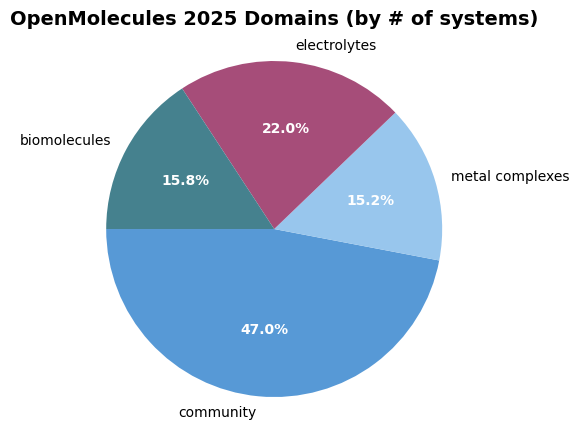

In [27]:
make_pie_chart(vert_counts2, "OpenMolecules 2025 Domains (by # of systems)")

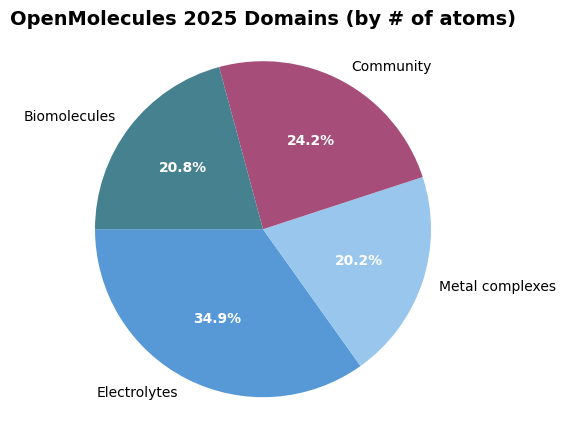

In [17]:
make_pie_chart(vertical_atoms, "OpenMolecules 2025 Domains (by # of atoms)")

In [ ]:
vertical_atoms

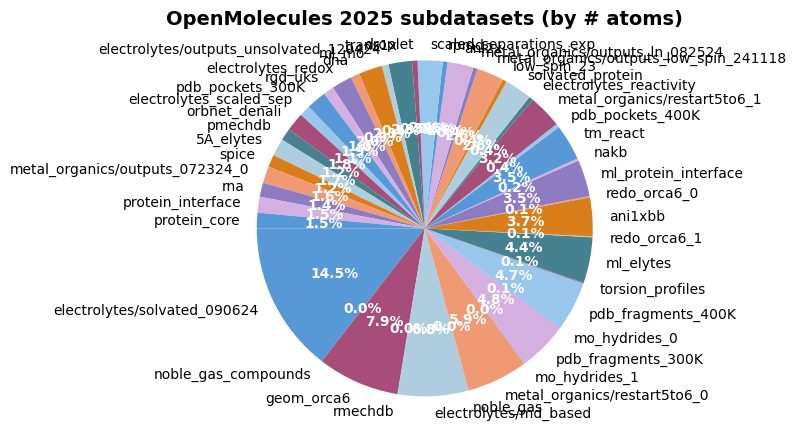

In [100]:
make_pie_chart(atom_counts, "OpenMolecules 2025 subdatasets (by # atoms)")

In [28]:
def partition_by_vertical(data):
    vert_partition = defaultdict(dict)
    for k,v in data.items():
        vert_partition[get_vertical(k)][k]=v
    return vert_partition

In [29]:
bio_grouping = {'pdb_fragments_300K': 'Protein-ligand (fragments)', 'pdb_fragments_400K': 'Protein-ligand (fragments)', 'pdb_pockets_300K': 'Protein-ligand (pockets)', 'pdb_pockets_400K': 'Protein-ligand (pockets)', 'protein_core': 'Protein-protein (core)', 'protein_interface': 'Protein-protein (interface)', 'solvated_protein':'Solvated Protein Fragments', 'rna': 'Protein-nucleic acid', 'dna':'Protein-nucleic acid', 'nakb': 'Protein-nucleic acid', 'ml_protein_interface':'ML-MD (proteins)', 'torsion_profiles': 'torsion scan'}
mc_grouping = {'metal_organics/restart5to6_0': 'Architector (spin-inert)', 'redo_orca6_0': 'Architector (spin-inert)', 'metal_organics/outputs_072324_0': 'Architector (spin-inert)', 'mo_hydrides_0': 'Architector (spin-inert)', 'metal_organics/restart5to6_1': 'Architector (high-spin)', 'redo_orca6_1': 'Architector (high-spin)', 'metal_organics/outputs_072324_1': 'Architector (high-spin)', 'mo_hydrides_1': 'Architector (high-spin)', 'metal_organics/outputs_ln_082524': 'Architector (spin-inert)', 'low_spin_23':'Architector (low-spin)', 'metal_organics/outputs_low_spin_241118':'Architector (low-spin)', 'tm_react':'Reactivity', 'ml_mo': 'ML-MD (metal complexes)'}
elyte_grouping = {'electrolytes/md_based':'3A clusters', '5A_elytes':'5A clusters', '7A_elytes': '7A clusters','electrolytes_scaled_sep': 'Scaled clusters', 'scaled_separations_exp': 'Scaled clusters', 'electrolytes_redox': 'Redoxed clusters', 'droplet':'Interface clusters', 'rpmd':'RPMD clusters', 'electrolytes/solvated_090624':'Random solvates', 'electrolytes/outputs_unsolvated_120424':'Random solvates', 'electrolytes_reactivity':'Reactivity', 'ml_elytes': 'ML-MD (electrolytes)', 'noble_gas': 'Noble gas', 'noble_gas_compounds': 'Noble gas'}
gen_grouping = {'ani2x':'ANI-2x','trans1x':'Transition-1x', 'geom_orca6':'GEOM', 'orbnet_denali':'Orbnet Denali', 'rgd_uks': 'RGD1', 'spice':'SPICE2', 'rmechdb':'MechDBs', 'pmechdb':'MechDBs', 'ani1xbb':'ANI-1xBB'}

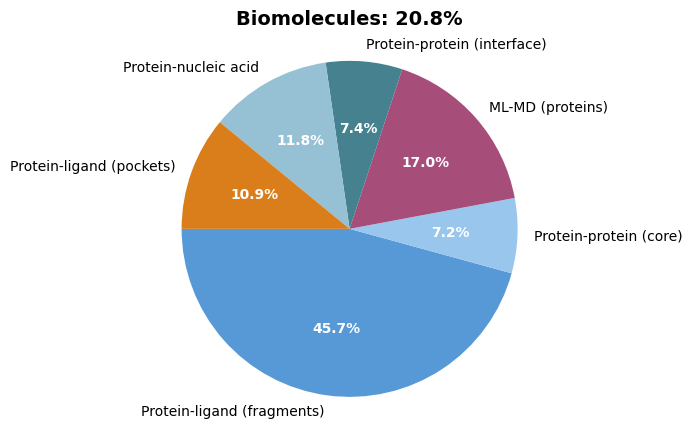

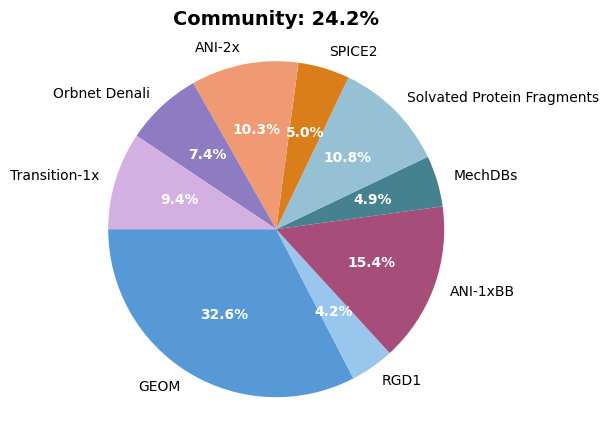

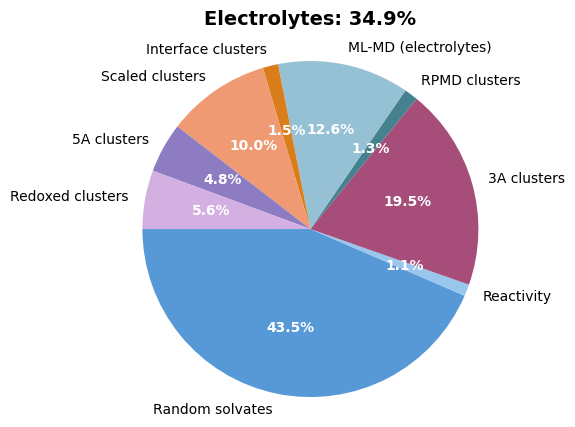

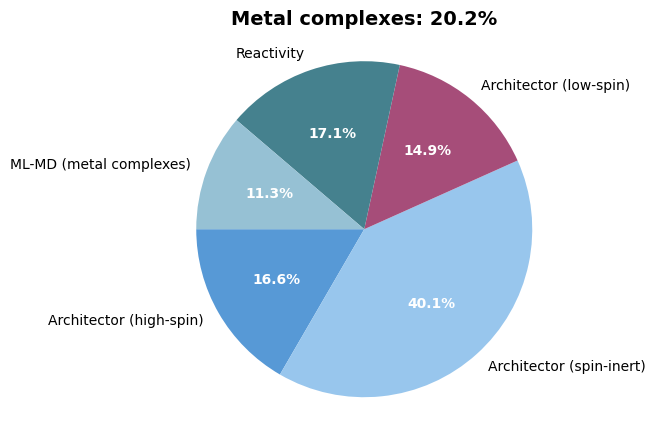

In [30]:
vert_parts =partition_by_vertical(atom_counts)
pretty_vert_parts = {}
pretty_dict = {**bio_grouping, **mc_grouping, **elyte_grouping, **gen_grouping}
vert_percent = {'biomolecules': '20.8%', 'metal complexes':'20.2%', 'community': '24.2%', 'electrolytes':'34.9%'}
for vert, breakdown in vert_parts.items():
    pretty_breakdown = Counter()
    for k, v in breakdown.items():
        if k in {'torsion_profiles', 'noble_gas', 'noble_gas_compounds','7A_elytes'}:
            continue
        pretty_breakdown[pretty_dict[k]] +=v 
    pretty_vert_parts[vert.capitalize() + f': {vert_percent[vert]}'] = pretty_breakdown
for vert, vert_part in pretty_vert_parts.items():
    make_pie_chart(vert_part, vert)

In [31]:
pretty_vert_parts

{'Biomolecules: 20.8%': Counter({'Protein-ligand (fragments)': 556029427,
          'ML-MD (proteins)': 206440886,
          'Protein-nucleic acid': 143110991,
          'Protein-ligand (pockets)': 133063120,
          'Protein-protein (interface)': 89362484,
          'Protein-protein (core)': 87654506}),
 'Community: 24.2%': Counter({'GEOM': 462509898,
          'ANI-1xBB': 217954929,
          'Solvated Protein Fragments': 153667041,
          'ANI-2x': 146681259,
          'Transition-1x': 133187893,
          'Orbnet Denali': 104889363,
          'SPICE2': 70354459,
          'MechDBs': 69800881,
          'RGD1': 59730917}),
 'Electrolytes: 34.9%': Counter({'Random solvates': 888888244,
          '3A clusters': 398098498,
          'ML-MD (electrolytes)': 258405228,
          'Scaled clusters': 203961065,
          'Redoxed clusters': 115291942,
          '5A clusters': 98249410,
          'Interface clusters': 30282515,
          'RPMD clusters': 27085777,
          'Reactivity'

In [32]:
sorted(elt_counts.items(), key=lambda x: x[1], reverse=True)

[('H', 2923777740),
 ('C', 1840928752),
 ('O', 509934829),
 ('N', 333946080),
 ('F', 66523062),
 ('S', 55029156),
 ('Cl', 40627217),
 ('P', 25892258),
 ('Br', 17634938),
 ('B', 6207724),
 ('Si', 6069050),
 ('I', 5358429),
 ('Se', 3227216),
 ('As', 1947551),
 ('Te', 1289434),
 ('Sb', 1232165),
 ('V', 1223422),
 ('Li', 1091028),
 ('Pd', 1024091),
 ('Ge', 1023794),
 ('Ti', 1023735),
 ('Ir', 973555),
 ('Pt', 965660),
 ('Na', 806262),
 ('Ru', 776398),
 ('Al', 747689),
 ('Mg', 737712),
 ('Fe', 719702),
 ('Mn', 711261),
 ('Co', 673075),
 ('K', 665480),
 ('Cr', 643436),
 ('Ca', 618216),
 ('Cu', 578774),
 ('Sn', 566172),
 ('In', 558941),
 ('Pb', 551116),
 ('W', 525568),
 ('Tl', 522406),
 ('Cs', 481092),
 ('Re', 472642),
 ('Be', 464889),
 ('Ag', 451230),
 ('Rb', 443075),
 ('Au', 434212),
 ('Sr', 434195),
 ('Hg', 428333),
 ('Y', 423525),
 ('Ba', 409888),
 ('Zn', 398534),
 ('Ga', 383010),
 ('Rh', 376261),
 ('Cd', 358137),
 ('Zr', 342797),
 ('Ni', 335593),
 ('Hf', 321277),
 ('Os', 307351),
 ('Mo', 

In [33]:
train_elt_system_counts

Counter({'H': 101009708,
         'C': 99451918,
         'O': 83046410,
         'N': 78182499,
         'S': 29441382,
         'P': 13898560,
         'F': 13690812,
         'Cl': 11121013,
         'Br': 5873982,
         'B': 4330453,
         'Si': 3912950,
         'I': 3760588,
         'Se': 1844411,
         'As': 1410894,
         'V': 1069133,
         'Te': 1054626,
         'Sb': 1053148,
         'Pd': 985555,
         'Ti': 980065,
         'Ir': 955690,
         'Pt': 926351,
         'Ge': 857996,
         'Li': 797405,
         'Ru': 760467,
         'Fe': 662509,
         'Mn': 640428,
         'Al': 611095,
         'Mg': 600600,
         'Co': 600437,
         'Cr': 585021,
         'Sn': 522445,
         'W': 516442,
         'Na': 504168,
         'K': 498816,
         'Pb': 498388,
         'Ca': 496508,
         'Tl': 490729,
         'In': 490377,
         'Cu': 485568,
         'Re': 462258,
         'Au': 421861,
         'Cs': 416313,
         'Y': 391327

In [128]:
import csv
with open('elt_count.csv', 'w', newline='\n') as fh:
    csv_writer = csv.writer(fh, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for row in train_elt_system_counts.items():
        csv_writer.writerow(row)

In [25]:
sum(system_counts.values()), sum(train_system_counts.values())

(107298220, 101666499)

In [26]:
sum(distinct_system_counts.values())

82719353

In [143]:
system_counts['pmechdb']

1152312

In [27]:
pretty_vert_parts

{'Biomolecules: 20.8%': Counter({'Protein-ligand (fragments)': 556029427,
          'ML-MD (proteins)': 206440886,
          'Protein-nucleic acid': 143110991,
          'Protein-ligand (pockets)': 133063120,
          'Protein-protein (interface)': 89362484,
          'Protein-protein (core)': 87654506}),
 'Community: 24.2%': Counter({'GEOM': 462509898,
          'ANI-1xBB': 217954929,
          'Solvated Protein Fragments': 153667041,
          'ANI-2x': 146681259,
          'Transition-1x': 133187893,
          'Orbnet Denali': 104889363,
          'SPICE2': 70354459,
          'MechDBs': 69800881,
          'RGD1': 59730917}),
 'Electrolytes: 34.9%': Counter({'Random solvates': 888888244,
          '3A clusters': 398098498,
          'ML-MD (electrolytes)': 258405228,
          'Scaled clusters': 203961065,
          'Redoxed clusters': 115291942,
          '5A clusters': 98249410,
          'Interface clusters': 30282515,
          'RPMD clusters': 27085777,
          'Reactivity'

In [ ]:
res_dict = {}
res_dict.update(pretty_vert_parts['Community: 24.2%'])
res_dict['OMol25'] = sum([sum(vert.values()) for k, vert in pretty_vert_parts.items()])

In [ ]:
res_dict

In [ ]:
del res_dict['Solvated Protein Fragments']
del res_dict['RGD1']
del res_dict['ANI-1xBB']
del res_dict['MechDBs']
del res_dict['GEOM']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
# Extract keys (labels) and values from the dictionary
import matplotlib.ticker as mticker
font = fm.FontProperties(fname='/private/home/levineds/Optimistic_Display_Lt.ttf')
fontbold = fm.FontProperties(fname='/private/home/levineds/Optimistic_Display_Bd.ttf')
fm.fontManager.addfont('/private/home/levineds/Optimistic_Display_Lt.ttf')
fm.fontManager.addfont('/private/home/levineds/Optimistic_Display_Md.ttf')
labels = list(res_dict.keys())
values = list(res_dict.values())
# Create the figure and axis
fig, ax = plt.subplots()
plt.xticks(rotation=45,fontproperties=font)
# Create the bar plot
#ax.bar(labels, values)
#5799d6','#98c6ed','#a64d79
ax.bar(labels[:-1], values[:-1], color='#a64d79')
ax.bar(labels[-1], values[-1], color='#5799d6') 
# Set title and labels
plt.tight_layout()
ax.set_title('Size of dataset (by number of atoms)',weight="bold", fontproperties=fontbold, fontsize=18)
#ax.set_xlabel('Dataset', fontproperties=font, fontsize=16)
ax.set_ylabel('Total number of atoms',fontproperties=font, fontsize=16)
formatter = mticker.ScalarFormatter(useOffset=False, useMathText=False)
#formatter.set_scientific(True)
def format_func(value, tick_number):
    return f'{value:.0e}'
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_func))

#ax.yaxis.set_major_formatter(formatter)
plt.savefig(f"DatasetSize.png", bbox_inches='tight', transparent=True, dpi=600)

In [57]:
system_counts
dsl = ['pdb_fragments_300K','pdb_fragments_400K','protein_interface','rna','protein_core','pdb_pockets_300K','dna','nakb','pdb_pockets_400K','torsion_profiles','noble_gas', 'noble_gas_compounds']
dsl_plus = ['electrolytes/solvated_090624','electrolytes/md_based','metal_organics/restart5to6_0','tm_react','metal_organics/restart5to6_1','metal_organics/outputs_low_spin_241118','electrolytes_reactivity','scaled_separations_exp','metal_organics/outputs_072324_0','electrolytes_redox','pmechdb','electrolytes/outputs_unsolvated_120424','electrolytes_scaled_sep','5A_elytes','droplet','metal_organics/outputs_ln_082524','low_spin_23','metal_organics/outputs_ln_082524','redo_orca6_0','redo_orca6_1','rmechdb','mo_hydrides_0','mo_hydrides_1','solvated_protein', 'ani2x', 'orbnet_denali', 'rgd_uks', 'spice', 'trans1x']
print(sum(atom_counts[f] for f in dsl))
print(sum(atom_counts[f] for f in dsl_plus))

1015388999
3571298355


In [55]:
print(sum(system_counts.values()))

107298220


In [48]:
print([key for key in system_counts if key not in dsl+dsl_plus])

['solvated_protein', 'rpmd', 'ani2x', 'orbnet_denali', 'rgd_uks', 'spice', 'trans1x', 'ani1xbb', 'ml_protein_interface', 'ml_mo', 'ml_elytes', 'geom_orca6', '7A_elytes']


In [53]:
4586687354/5867882916

0.781659658118509

In [56]:
80117870/107298220

0.7466840549638195

In [58]:
1015388999/5867882916

0.1730417960848079

In [60]:
3571298355/5867882916

0.6086178620337012

In [84]:
system_counts

Counter({'ani1xbb': 13345747,
         'electrolytes/solvated_090624': 9726613,
         'ani2x': 9647265,
         'trans1x': 9569752,
         'geom_orca6': 8958415,
         'solvated_protein': 7197825,
         'electrolytes/md_based': 4508089,
         'metal_organics/restart5to6_0': 4215586,
         'tm_react': 3490192,
         'rgd_uks': 3359478,
         'metal_organics/restart5to6_1': 2530774,
         'orbnet_denali': 2336688,
         'pdb_fragments_300K': 2270864,
         'pdb_fragments_400K': 2258915,
         'metal_organics/outputs_low_spin_241118': 2120347,
         'spice': 1999838,
         'electrolytes_reactivity': 1775390,
         'ml_elytes': 1698034,
         'ml_mo': 1695461,
         'scaled_separations_exp': 1464197,
         'ml_protein_interface': 1442493,
         'metal_organics/outputs_072324_0': 1322450,
         'electrolytes_redox': 1284735,
         'pmechdb': 1152312,
         'protein_interface': 923776,
         'electrolytes/outputs_unsolvated

In [63]:
system_counts-distinct_system_counts

Counter({'electrolytes/solvated_090624': 8073882,
         'solvated_protein': 4797849,
         'tm_react': 3337214,
         'electrolytes/md_based': 2859285,
         'metal_organics/outputs_low_spin_241118': 1955951,
         'metal_organics/outputs_072324_0': 1239215,
         'pmechdb': 1059411,
         'electrolytes/outputs_unsolvated_120424': 735119,
         'metal_organics/outputs_ln_082524': 233451,
         'redo_orca6_0': 94315,
         'torsion_profiles': 76346,
         'rmechdb': 58901,
         'redo_orca6_1': 57493,
         'noble_gas_compounds': 435})

In [74]:
import os
opt_counts = Counter()
seen_opt_basenames = set()
for idx, stats in enumerate(data_stats):
    for stat in tqdm(stats.values(), total=len(stats)):
        if 'step' not in stat['source']:
            continue
        bname = os.path.dirname(os.path.dirname(stat['source']))
        if bname not in seen_opt_basenames:
            opt_counts[stat['subdataset']] += 1
            seen_opt_basenames.add(bname)
    if idx == 0:
        train_opt_counts = Counter(distinct_system_counts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24669/24669 [00:00<00:00, 631692.19it/s]


In [65]:
opt_counts

Counter({'solvated_protein': 2399976,
         'electrolytes/solvated_090624': 1652731,
         'electrolytes/md_based': 1648804,
         'metal_organics/outputs_low_spin_241118': 164396,
         'tm_react': 152978,
         'electrolytes/outputs_unsolvated_120424': 148730,
         'pmechdb': 92901,
         'metal_organics/outputs_ln_082524': 84057,
         'metal_organics/outputs_072324_0': 83235,
         'redo_orca6_0': 16150,
         'redo_orca6_1': 10589,
         'rmechdb': 4676,
         'torsion_profiles': 3564,
         'noble_gas_compounds': 42,
         'pdb_fragments_300K': 0,
         'pdb_fragments_400K': 0,
         'pdb_pockets_300K': 0,
         'pdb_pockets_400K': 0,
         'protein_core': 0,
         'rna': 0,
         'dna': 0,
         'nakb': 0,
         'protein_interface': 0,
         '5A_elytes': 0,
         'electrolytes_scaled_sep': 0,
         'scaled_separations_exp': 0,
         'electrolytes_redox': 0,
         'droplet': 0,
         'rpmd': 0,
 

In [81]:
next(val for val in data_stats[0].values() if val['subdataset'] =='metal_organics/restart5to6_0')

{'subdataset': 'metal_organics/restart5to6_0',
 'vertical': 'metal_complexes',
 'elts': Counter({'H': 47,
          'C': 33,
          'N': 10,
          'O': 2,
          'S': 2,
          'Si': 1,
          'Sr': 1}),
 'source': 's3://opencatalysisdata/archive/hot/omol/metal_organics/restart5to6/job_1741077523_62d5df23d602/orca.tar.zst'}

In [76]:
opt_counts

Counter({'solvated_protein': 2409610,
         'electrolytes/md_based': 1661457,
         'electrolytes/solvated_090624': 1659044,
         'metal_organics/outputs_low_spin_241118': 276943,
         'metal_organics/outputs_072324_0': 176032,
         'electrolytes/outputs_unsolvated_120424': 148735,
         'metal_organics/outputs_ln_082524': 92096,
         'redo_orca6_0': 37727,
         'redo_orca6_1': 24813,
         'torsion_profiles': 3564,
         'tm_react': 1,
         'noble_gas_compounds': 1,
         'pmechdb': 1,
         'rmechdb': 1})

In [77]:
len(seen_opt_basenames)

6490025

In [79]:
for i in data_stats[0]:
    if i.startswith('s3://opencatalysisdata/archive/hot/omol/electrolytes/md_based/outputs_241029/1000_Ag+_3_group_0_shell_0_0_1'):
        print(i)

s3://opencatalysisdata/archive/hot/omol/electrolytes/md_based/outputs_241029/1000_Ag+_3_group_0_shell_0_0_1/step0/orca.tar.zst
s3://opencatalysisdata/archive/hot/omol/electrolytes/md_based/outputs_241029/1000_Ag+_3_group_0_shell_0_0_1/step1/orca.tar.zst
s3://opencatalysisdata/archive/hot/omol/electrolytes/md_based/outputs_241029/1000_Ag+_3_group_0_shell_0_0_1/step2/orca.tar.zst


In [80]:
system_counts['redo_orca6_0']

110465

In [87]:
(4215586+2530774)/7.5

899514.6666666666

In [85]:
1322450/176032

7.512554535538993

In [89]:
276943+176032+92096+899514+37727+24813

1507125

In [90]:
2409610+1661457+1659044+148735

5878846

In [91]:
del seen_opt_basenames

In [34]:
system_counts

Counter({'ani1xbb': 13345747,
         'electrolytes/solvated_090624': 9726613,
         'ani2x': 9647265,
         'trans1x': 9569752,
         'geom_orca6': 8958415,
         'solvated_protein': 7197825,
         'electrolytes/md_based': 4508089,
         'metal_organics/restart5to6_0': 4215586,
         'tm_react': 3490192,
         'rgd_uks': 3359478,
         'metal_organics/restart5to6_1': 2530774,
         'orbnet_denali': 2336688,
         'pdb_fragments_300K': 2270864,
         'pdb_fragments_400K': 2258915,
         'metal_organics/outputs_low_spin_241118': 2120347,
         'spice': 1999838,
         'electrolytes_reactivity': 1775390,
         'ml_elytes': 1698034,
         'ml_mo': 1695461,
         'scaled_separations_exp': 1464197,
         'ml_protein_interface': 1442493,
         'metal_organics/outputs_072324_0': 1322450,
         'electrolytes_redox': 1284735,
         'pmechdb': 1152312,
         'protein_interface': 923776,
         'electrolytes/outputs_unsolvated